# Report on concurrent FP-Growth implementation in Python
> Spampinato Marco, March 28th, 2025

## Introduction
A concurrent implementation of the popular FP-Growth algorithm has been proposed as exam project for Data Mining course at UNICT.  
This document provides a report of such experience, along with considerations and background on the work done.
### Frequent itemsets mining
Frequent Itemsets Mining (FIM) is, after preprocessing, often the first topic discussed in Data Mining courses around the world, as its striking importance in solving problems such as _market basket analysis_, _recommendation systems_ and many more data mining problems.

The classic goal of FIM applied in market basket analysis is to find those items which are often found together in same transactions, so to then infer association rules, such as the classic:
$$Diapers \longrightarrow Beer$$
In order to infer such association, it's necessary that many transactions contain both _Beer_ and _Diapers_, and that's what a FIM algorithm solves.

There are three kinds of algorithms that searches for frequent itemsets:
- **Apriori**, uses a generational approach by computing candidates.
- **ECLAT**, an alternative of Apriori which generates candidates using TIDs.
- **FP-Growth**, a method based on prefix tree mining, of which this project provides an implementation, it is supposed to be faster than Apriori.

### FP-Growth algorithm
FP-Growth is a fun algorithm, as mentioned before, it involves in mining a prefix tree, which represents the whole database of transaction compressed.

Roughly, one can sum up the FP-Growth algorithm in three steps:
1. Frequent items collection.
    - A linear scan over the database is performed to collect those items which support is greater or equal than the minimum one.
    - The items then get sorted in order descending order of support.
2. FP-Tree construction.
    - A linear scan over the database constructs the FP-Tree, which represents a compressed database.
3. FP-Tree mining.
    - By projecting the tree bottom-up by item, frequent itemsets are collected by traversing the paths upwards.

### Motivations and goals
During class we had the opportunity to practice with both Apriori and FP-Growth algorithms.  
Most, if not all, of us students used the _mlxtend_ library which provided implementations for both algorithms along with association rules extraction.

One observation on those practices is that neither of the provided implementations used more than one computational unit, that's it, they are not using all our CPU's cores, which in the previous years doubled or quadrupled in counts, to our benefits and content.

And while Apriori could be tweaked not to allocate illegaly huge amounts of RAM, that was not the case for FP-Growth, which could take even up to 40GB of memory, leading to nasty thrashing if the tree couldn't fit in memory.

Thus an alternative implementation of FP-Growth has been proposed and accepted as project exam, with the following goals:
- The implementation must take advantage of multi-core processors.
- The implementation must use less memory.

Concurrent programming is achieved by means of multi-processing, due to limits on CPython's runtime.

## Trial and error constructing the FP-Tree
I talked big when I proposed the project, to my detriment.

Different research papers on novel FP-Growth methods have been explored, nonetheless due to technical language barrier, I failed to understand one [[1]](#Bibliography), had a totally different interpretation, and took me busy for a while.

### Partitioning algorithm
 Christian Borglet in [[1]](#Bibliography) describes a method of constructing the FP-Tree by _splitting_ the database recursively into sections: my wrong interpretation of that has been a recursive partitioning of the transaction database from the most to the least frequent item, thus creating a tree of partitions.

The algorithm is implemented in `old_code/old/algorithm2.py` and its precedent versions, along with a failed multi processing implementation, it can roughly be summarized with:

```txt
root = root node spanning the whole dataset
levels = { {root} }
right_parititions = {}

for each frequent item in descending order of support:
    next_level = {}
    next_right = {}
    for each partition in previous level U right_partitions:
        left = transactions having item
        right = transactions not having item
        add left to next_level
        add right to next_right

    add next_level to levels
    swap right_partitions with next_right

return levels
```

While tricks and hacks have been used to have this peform as fast as possible, it has to scan the database multiple times, thus while the result is correct, it is too slow.

A concurrent prototype has been coded, but due to restrictions in Python's concurrency implementation, it has been promptly abandoned.

Although not optimal for use in standard processors, the algorithm should be tested on GPUs, where standard FP-Tree construction algorithms may not even be possible. 

### A more classic implementation
I have decided to implement a more classic, FP-Tree as prefix tree, one transaction at a time.

The algorithm, which is similar to the final implementation, has been definitely faster than the partition method, but had the same side effect as _mlxtend_'s one of using too much memory.

From the partition method, I brought forward the idea of left and right.

The following database:

| TID | Transaction items ordered by frequent item |
|-----|--------------------------------------------|
| 100 | f, c, a, m, p                              |
| 200 | f, c, a, b, m                              |
| 300 | f, b                                       |
| 400 | c, b, p                                    |
| 500 | f, c, a, m, p                              |

Can be virtually represented with a pivot table:

| f | c | a | b | m | p |
|---|---|---|---|---|---|
| 1 | 1 | 1 | 0 | 1 | 1 |
| 1 | 1 | 1 | 1 | 1 | 0 |
| 1 | 0 | 0 | 1 | 0 | 0 |
| 0 | 1 | 0 | 1 | 0 | 1 |
| 1 | 1 | 1 | 0 | 1 | 1 |

Whenever an item is present in transaction, a left node is used, else a right node.

On real databases, the pivot table would be very sparse, thus leading to a huge amount of right nodes if no compression is used, and longer traversals time.  
Additionally, Python objects would reserve some more memory for metadata and garbage collection, thus leading to more memory usage than expected.

The final implementation will address these issues.

## FP-Growth implementation
The implemented FP-Growth uses the standard, one at a time, approach to build the tree, and computes maximal frequent itemsets.

A frequent item preprocessor is used to compute frequent items through the _fit_ method, and _transform_ is used to process each transaction before feeding it to the FP-Tree for construction, items are relabeled.

The FP-Tree does not uses objects as nodes, instead allocating a node means allocating its attributes in a series of arrays, no additional metadata or garbage collection book-keeping is needed, a node is represented by its index.
Memory is also contiguous, thus more cache friendly.

Right nodes, which are logically similar to edges, are compressed:
A right edge denotes an edge from a left node to the immediate antecedent of the next, some fairly complex logic is used to split and traverse right edges.

Finally, the itemsets extraction works by recursive projection of each label's node.

In multiprocessing, the itemsets extraction part is dispatched to child processes.

### Preprocessing
Preprocessing is done by class `FrequentItemPreprocessor` (FIP), its constructor accepts a required `min_support` parameter and `max_support` parameter; it has two methods:
- `fit` accepts a sequence of transactions and will construct the headers table data.
- `transform` accept a transaction and returns a relabeled transaction, ordered in order of decreasing support.
- `to_item` and `to_items` transform either a single label and a list of labels back to item or items. 

The `FrequentItemPreprocessor` is used internally.

### FP-Tree
The FP-Tree is implemented by class `FlatFPTree`.

The constructor accepts a `FrequentItemPreprocessor` and would then initialize class state, the next node id and node attributes arrays ( type, label, count, parent, left, right ) to empty arrays.  
Finally, for each label, a list of nodes is initialized with a first empty node, which will then be used as de factor root for every transaction starting with such label.

A set of accessors and setters are available for easier node manipulation.

#### Adding a transaction
A transaction is added via `add_transaction`, the transaction is first tramsformed via the FIP, and tested for a valid length.

A private implementation of `add_transaction` will start by selecting the first node represented by the first label of the transformed transaction, will then increment the node uses, and for each label, traverse the tree and increment each label's node uses.

Traversing is done by the `traverse` method, which will traverse, split and create edges and nodes at need, roughly the method pseudocode is:
```txt
if destination label is immediate successor of source label:
    return the node on the left of node, create if needed
else:
    right_destination_label = immediate predecessor of destination label
    right = edge on the right of node
    if right does not exists:
        create right edge
        create and return right edge's left node 
    else:
        if right edges's label is greater than right_destination_node:
            split right edge
            return right edge
        else:
            right = first existing right edge before right_destination_label
            traverse right
```
#### Tree projection and mining
Tree projection is naively done recursively by `project_and_mine_tree`, for each label:
1. Upwards paths from each label's node are computed.
    - If paths length is one, construct an itemset from that path.
    - If paths lenght is greater than one, recursively construct and mine a new tree using paths as databases, collect frequent itemsets.
2. Return collected itemsets along with the header of label.

#### Itemset extraction and concurrency
Method `extract_itemsets` of the FP-Tree will select between two paths of execution, depending on `max_workers` params.

If `max_workers = 0`, itemsets extraction is peformed on the main process.

If `max_workers > 0`, a pool of child processes is spawned by `ProcessPoolExecutor`, they are initialized with a copy of the original FP-Tree.  
An array of indices to labels is computed and shuffled, then naively split into a grid of `max_workers` chunks, ultimately dispatched to the executor.  
The results are then merged together.

Itemsets extraction is ultimately delegated by running `project_tree` for each label in the workset.

#### Facade
Function `fpgrowth_mp` is provided as facade for the entire algorithm, it accepts the minimum support parameter, the transaction database as list of transactions, an optional number of max workers.

By default, max workers is set as the number of threads of the host computer.  
If max workers is set to zero the algorithm will run only in the main process.

Function `fpgrowth` is alias `fpgrowth_mp` with `max_workers` set to zero, so, to run on main process.

### Performances
The performance is evaluated with different datasets against _mlxtend's_ provided algorithms.

The used datasets are:
- **T10I4D100K**, a synthetic database generated using the IBM Quest generator. 
- **retail**, a dataset donated by Tom Brijs and contains the (anonymized) retail market basket data from an anonymous Belgian retail store.
- **scontrini**, another dataset provided by our professor similar to _retail_, items have been anonymized, but I can not provide any public release of such dataset without authorization.

Both _retail_ and _T10I4D100K_, along with other datasets, can be found [here](http://fimi.uantwerpen.be/data/).

Benchmarks are run in both standard ( _fpgrowth_sp_ ), and multiprocessing ( _fpgrowth_mp_ ) variations of the algorithm.

The machine used for benchmark has a AMD Ryzen 7 9700X 8 cores / 16 threads processor and 64GiB of RAM.

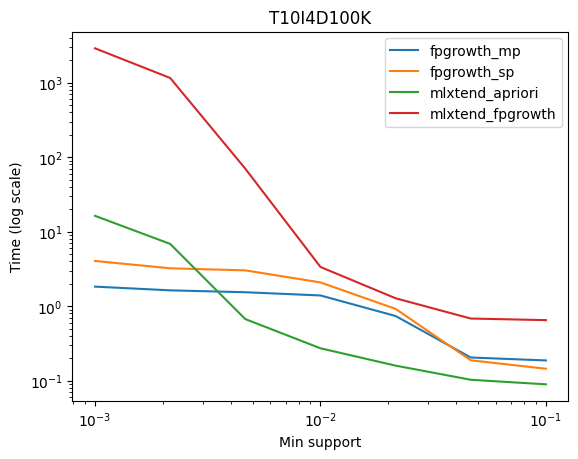

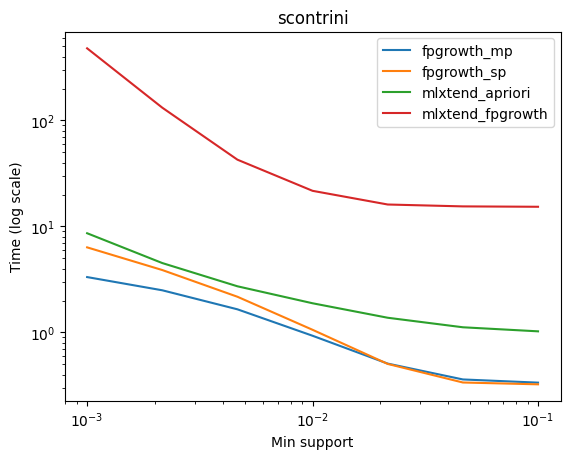

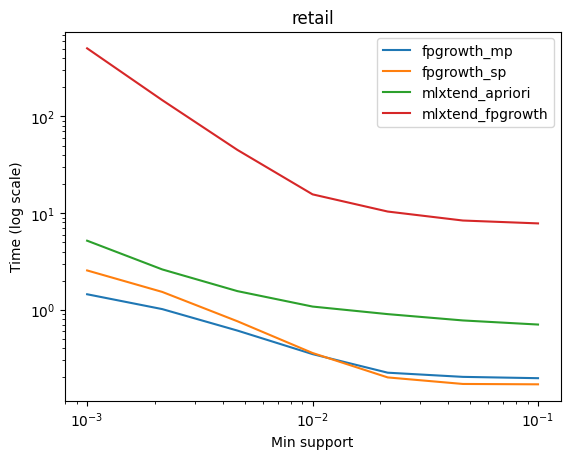

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('data/benchmarks.nogit.csv')
datasets = df['dataset'].unique()
algos = df['algorithm'].unique()
for name in datasets:
  dataset = df[df['dataset'] == name]
  plt.title(name)
  plt.yscale('log')
  plt.xscale('log')
  
  plt.ylabel('Time (log scale)')
  plt.xlabel('Min support')
  for algo in algos:
    data = dataset[dataset['algorithm'] == algo]
    plt.plot(data['min_support'],data['runtime'], label=algo)
    plt.legend()
  plt.show()

### Considerations
As shown in the plots, _mlxtend's_ FP-Growth implementation fails to deliver expected performance gains over Apriori.  

The _single process configuration_ of the proposed algorithm performs very well, despite the naive implementation of the core projection method.

The _multi process configuration_ does not show impressive gains over the single process one.  
Plots show that at a certain _min\_support_, it gets slower than its single process variant, that's due to the naive method of instancing workers based on the number of processors Python reads as available, thus some time is lost in code which is not the algorithm's , as system calls, IPC, and so on...

## Final words
The proposed algorithm satisfies the required goals of better runtimes and better CPU resource usage over mlxtend's implementations.

The results are almost on pair with mlxtend's, delivering same results in most datasets, but failing in more dense, with a margin of a few percent of frequent itemsets not mined.

Enough time has been dedicated to this project, I conclude this project with the remaining issues.


#### Bibliography
1. **An Implementation of the FP-growth Algorithm**  
    Christian Borgelt  
    Workshop Open Source Data Mining Software (OSDM'05, Chicago, IL), 1-5.  
    ACM Press, New York, NY, USA 2005.  
2. **"Mining frequent patterns without candidate generation. "A frequent-pattern tree approach."**  
    Han, Jiawei, Jian Pei, Yiwen Yin, and Runying Mao.  
    Data mining and knowledge discovery 8, no. 1 (2004): 53-87.